In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Time shift 
shift_dic = {
    'DS' : 0,
    'MS' : 1,
    'ES' : 2
}

data_idx_dic = {
    0 :'last',
    1 :'first',
    2 :'mean',
    3 :'max',
    4 :'min',
    5 :'max-last',
    6 :'max, last',
    7 :'mean, last'
}

## 2018-7-10 idx 
split_idx = 158

df_s = pd.read_csv('supply.csv')
df_d = pd.read_csv('demand.csv')

In [3]:

def apply_timedelta(col):
    
    ## return the timeslot day & time 
    
    day = col[0] 
    timeslot = col[1]
    cal_time= col[2]
    
    # slot-day&time 
    td_slot_str = day +" "+timeslot
    td_slot = datetime.datetime.strptime(td_slot_str, '%Y-%m-%d %H:%M')
    cal_time = datetime.datetime.strptime(cal_time, '%Y-%m-%d %H:%M:%S')
    time_delta = ((td_slot - cal_time).total_seconds())/3600 # in hours 
    
    return pd.Series((td_slot, int(time_delta)))  #[td_slot, time_delta]

def return_date_hour(col):
    hour = str(col)[22:27]
    date = str(col)[11:21]
    
    return pd.Series((str(date), str(hour)))  

def return_week_shift(col):
    
    hour = col[1]
    date = col[0]
    
    td_slot = datetime.datetime.strptime(date+" "+hour, '%Y-%m-%d %H:%M')
    
    #date_dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    weekday = td_slot.weekday()
    
    m_time = datetime.time(11, 0)
    e_time = datetime.time(16, 0)
    
    time_shift = 0 
    if weekday == 0: # Mon
        if td_slot.time() <= m_time :
            time_shift = shift_dic['MS']
        else:
            time_shift = shift_dic['ES']
    elif weekday == 1: # Thu
        time_shift = shift_dic['MS']
    elif weekday == 2: # Wed
        if td_slot.time() <= m_time :
            time_shift = shift_dic['MS']
        else:
            time_shift = shift_dic['ES']
    elif weekday == 4: # Fri
        time_shift = shift_dic['MS']
    elif weekday == 5: # Sat
        time_shift = shift_dic['MS']
            
    return pd.Series(( int(weekday), int(time_shift)))  


## (1) From supply.csv -> find the time_delta between slot and calculated time

In [4]:
df_s[['timeslot','timedelta']] = df_s[['day', 'timeslot_from', 'calculated_datetime']].apply(apply_timedelta, axis=1)
df_s.head()

,day,timeslot_from,calculated_datetime,grid_unit,avail_area_ratio,timeslot,timedelta
0,2018-01-08,05:30,2017-12-20 16:00:04,1,0.00,2018-01-08 05:30:00,445
1,2018-01-08,06:00,2017-12-20 16:00:04,1,0.37,2018-01-08 06:00:00,445
2,2018-01-08,06:00,2018-01-03 07:05:44,1,0.37,2018-01-08 06:00:00,118
3,2018-01-08,06:00,2018-01-03 08:14:53,1,0.37,2018-01-08 06:00:00,117
4,2018-01-08,06:00,2018-01-03 08:16:26,1,0.37,2018-01-08 06:00:00,117


## (2) Exclude the data that has ( - ) time delta 

In [5]:
print (df_s.shape)
df_s = df_s[(df_s['timedelta']>=0)]
print (df_s.shape)

(5082605, 7)
(4984118, 7)


## (3) Plot the distribution of timedelta

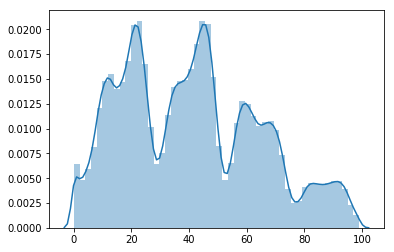

In [6]:
ax = sns.distplot(list(df_s[(df_s['timedelta']<100)]['timedelta']))

## (4) Group the data by the timeslot and grid unit 

In [7]:
df_supply_group = df_s.groupby(['timeslot','grid_unit'])['avail_area_ratio'].agg(['min','max','mean', 'count', 'first', 'last'])
df_supply_group['max-last'] = df_supply_group['max'] - df_supply_group['last']
df_supply_group.head()

min  max  mean  count  first  last  max-last
timeslot            grid_unit                                              
2018-01-01 06:00:00 1          0.0  0.0   0.0      1    0.0   0.0       0.0
                    2          0.0  0.0   0.0      1    0.0   0.0       0.0
                    3          0.0  0.0   0.0      1    0.0   0.0       0.0
                    4          0.0  0.0   0.0      1    0.0   0.0       0.0
                    5          0.0  0.0   0.0      1    0.0   0.0       0.0

- idx 0 : Last Time Calculated Value
- idx 1 : First Time Calculated Value
- idx 2 : Mean Calculated Value
- idx 3 : Max Calculated Value 
- idx 4 : Min Calculated Value 
- idx 5 : max-last (difference)

## (5) make the training data using 5 main factor (min, max, mean, first, last )

In [8]:
df_data_lst = []

df_selected = df_supply_group[~((df_supply_group['min']==0)&(df_supply_group['max']==0)&(df_supply_group['mean']==0))]
unique_slot = df_selected.index.get_level_values('timeslot').unique()

for col_indx in [5, 4, 2, 1, 0, 6]:
    df_new = pd.DataFrame(index=np.arange(0, len(unique_slot)), columns=['timeslot']+['grid_'+str(x) for x in range(1,32)])
    idx = 0
    for item in unique_slot:
        df_new.iloc[idx,1:]=list(df_supply_group.iloc[(df_supply_group.index.get_level_values('timeslot') == item)].T.iloc[col_indx])
        idx += 1
    
    df_new = df_new.apply(pd.to_numeric)
    df_new['timeslot'] = unique_slot
    df_new['timeslot'] = pd.to_datetime(df_new['timeslot'])
    df_new[['day', 'time']] = df_new[['timeslot']].apply(return_date_hour, axis=1)
    df_new[['weekday', 'shift']] = df_new[['day', 'time']].apply(return_week_shift, axis=1)
    df_data_lst.append(df_new)

df_data_lst[0].head()

,timeslot,grid_1,grid_2,grid_3,grid_4,grid_5,grid_6,grid_7,grid_8,grid_9,grid_10,grid_11,grid_12,grid_13,grid_14,grid_15,grid_16,grid_17,grid_18,grid_19,grid_20,grid_21,grid_22,grid_23,grid_24,grid_25,grid_26,grid_27,grid_28,grid_29,grid_30,grid_31,day,time,weekday,shift
0,2018-01-03 06:00:00,0.0,0.0,0.25,0.81,1.00,1.00,1.00,1.0,0.75,0.19,0.13,0.94,0.13,0.00,0.69,0.25,0.00,0.00,0.0,0.00,0.0,0.25,0.38,0.25,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-03,06:00,2,1
1,2018-01-03 06:30:00,0.0,0.0,0.00,0.31,0.87,0.94,0.38,0.0,0.12,0.00,0.00,0.44,0.19,0.31,1.00,1.00,0.13,0.69,0.0,0.38,0.0,0.56,1.00,0.56,0.12,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-03,06:30,2,1
2,2018-01-03 07:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.06,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-03,07:00,2,1
3,2018-01-03 07:30:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-03,07:30,2,1
4,2018-01-03 08:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-03,08:00,2,1


In [9]:
df_d = pd.read_csv('demand.csv')
df_d['shift'] = df_d['shift'].apply(lambda x: 1 if x == 'MS' else 2)
df_d.head()

,day,shift,num_pickups
0,2018-08-08,1,61
1,2018-02-14,1,75
2,2018-05-09,1,110
3,2018-06-04,1,67
4,2018-07-03,1,59


## (6) sum-up the 5-factors during the time shift 

In [43]:

df_data_new_group = []

for item in df_data_lst:
    tmp = item.groupby(['day','shift']).sum().drop(['weekday'], axis=1)
#    tmp['count_time_slot'] = item.groupby(['day','shift']).count()['timeslot']
    tmp.to_csv('./tmp.csv')
    tmp = pd.read_csv('./tmp.csv')
    tmp['weekday'] = tmp['day'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())
    tmp = pd.merge(tmp, df_d, on=['day','shift'])
    df_data_new_group.append(tmp)

df_data_new_group[0].head()

,day,shift,grid_1,grid_2,grid_3,grid_4,grid_5,grid_6,grid_7,grid_8,grid_9,grid_10,grid_11,grid_12,grid_13,grid_14,grid_15,grid_16,grid_17,grid_18,grid_19,grid_20,grid_21,grid_22,grid_23,grid_24,grid_25,grid_26,grid_27,grid_28,grid_29,grid_30,grid_31,weekday,num_pickups
0,2018-01-03,1,0.0,0.0,0.25,1.12,1.87,1.94,1.51,1.44,0.87,0.19,0.13,1.44,0.32,0.31,1.69,1.25,0.13,0.69,0.00,0.38,0.0,0.81,1.44,0.81,0.12,0.0,0.00,0.0,0.00,0.0,0.0,2,118
1,2018-01-03,2,0.0,0.0,0.00,0.00,0.44,0.50,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.19,0.00,0.00,0.00,0.00,0.0,0.06,0.19,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,2,69
2,2018-01-05,1,0.0,0.0,0.00,0.00,0.38,0.00,0.00,0.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4,29
3,2018-01-06,1,0.0,0.0,0.00,0.00,0.13,0.00,0.19,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,5,25
4,2018-01-08,1,0.0,0.0,0.00,0.00,0.06,0.31,0.81,0.19,0.00,0.00,0.00,0.62,0.06,0.00,0.13,0.06,0.00,0.00,0.38,0.00,0.0,0.00,0.37,0.00,0.00,0.0,0.06,1.5,0.44,0.0,0.0,0,102


In [44]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

In [45]:
def grid_cv(model, param, data_list, CV=5):
    rtn_df = pd.DataFrame()
    rtn_df['day'] = data_list[0].iloc[split_idx:,0].values
    rtn_df['shift'] = data_list[0].iloc[split_idx:,1].values
    rtn_df['Y_valid'] = data_list[0].iloc[split_idx:,-1].values
    rtn_mse_score = []
    
    print ('--- CV result from data ---')
    
    for idx in range(0,8): #data_list:
        if idx < 6:
            df_data=data_list[idx]
            X = df_data.iloc[:,2:-1].values
            y = np.log(df_data.iloc[:,-1].values)
        elif idx == 6:
            ## feature combination 
            # - max , last
            X = np.hstack (( data_list[3].iloc[:,2:-2].values , data_list[0].iloc[:,2:-1].values  ))
        elif idx == 7:
            ## feature combination 
            # - mean, last
            X = np.hstack (( data_list[2].iloc[:,2:-2].values , data_list[0].iloc[:,2:-1].values  ))         
        y = np.log(df_data.iloc[:,-1].values)
    
        X_train = X[:split_idx]
        X_valid = X[split_idx:]
        y_train = y[:split_idx]
        y_valid = y[split_idx:]
                
        grid = GridSearchCV(model, param_grid = param, n_jobs=4, cv=CV, verbose=0,scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        print ('Data Idx :{}'.format(data_idx_dic[idx]))
        print ('Best Param :{}'.format(grid.best_params_))
        print ('Best Score :{:.2f}'.format(np.sqrt(-grid.best_score_)))
        rtn_df[str(data_idx_dic[idx])+'_feat'] = np.exp(grid.predict(X_valid))
        rtn_mse_score.append(np.sqrt(mean_squared_error(np.exp(y_valid),np.exp(grid.predict(X_valid)))))
    
    return rtn_df, rtn_mse_score

## SVR CV results

In [46]:

svr_param = {
        'kernel' : ['rbf'],
        'C' : [1e-3, 1e-2, 1e-1, 1, 10],
        'gamma' : [1e-3, 1e-2, 1e-1, 1, 10]
    }

rtn_df, rtn_mse = grid_cv(SVR(),svr_param, df_data_new_group, CV = 5)
rtn_df.head(10)

--- CV result from data ---
Data Idx :last
Best Param :{'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
Best Score :0.42
Data Idx :first
Best Param :{'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
Best Score :0.44
Data Idx :mean
Best Param :{'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
Best Score :0.33
Data Idx :max
Best Param :{'kernel': 'rbf', 'C': 1, 'gamma': 10}
Best Score :0.33
Data Idx :min
Best Param :{'kernel': 'rbf', 'C': 1, 'gamma': 1}
Best Score :0.43
Data Idx :max-last
Best Param :{'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
Best Score :0.34
Data Idx :max, last
Best Param :{'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}
Best Score :0.35
Data Idx :mean, last
Best Param :{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
Best Score :0.34


,day,shift,Y_valid,last_feat,first_feat,mean_feat,max_feat,min_feat,max-last_feat,"max, last_feat","mean, last_feat"
0,2018-07-10,1,38,52.316956,53.369407,60.807055,58.461069,60.029336,73.486196,69.240198,67.476986
1,2018-07-11,1,64,47.387065,55.188164,62.364747,65.638082,55.262573,72.189741,67.111279,63.505451
2,2018-07-11,2,26,51.360491,55.188164,40.220822,39.467029,55.262573,51.535323,50.514274,41.111706
3,2018-07-13,1,81,47.281114,75.119072,60.896102,70.991723,75.137555,67.249362,67.024792,70.972959
4,2018-07-14,1,49,57.842584,39.802120,38.246539,53.394967,38.151498,70.382214,69.542427,51.588667
5,2018-07-16,1,86,55.161196,65.139370,77.516537,71.545126,63.339079,69.377465,70.129218,73.017505
6,2018-07-16,2,64,52.426481,65.139370,86.629303,62.834790,63.339079,52.118005,51.853622,68.639406
7,2018-07-17,1,46,103.697387,53.369407,67.815330,58.461069,62.954835,108.462611,79.992629,98.275798
8,2018-07-18,1,49,68.544802,55.188164,70.731173,66.470347,55.262573,76.982227,77.672495,87.877341
9,2018-07-18,2,30,60.972139,55.188164,41.977954,38.902720,55.262573,59.292666,58.545864,57.969499


In [47]:
rtn_mse

[26.83308670025734,
 13.78609731603268,
 22.342002564158754,
 15.760680918394952,
 15.367974337687738,
 26.402404454906442,
 20.99901120748164,
 24.98825859616167]

In [50]:
xgb_param = {
        'colsample_bytree':[0.1, 0.2,0.4],
        'gamma':[0.01,0.05, 0.1],
        'min_child_weight':[0.5, 1.5],
        'learning_rate':[0.15, 0.12, 0.1 ],
        'max_depth':[3,5,7],
        'n_estimators':[50, 100],
        'reg_alpha':[ 1e-3, 1e-2,  0.75],
        'reg_lambda':[1e-5, 1e-3, 1e-2],
        'subsample':[0.2, 0.4, 0.6]  
    }

rtn_df, rtn_mse = grid_cv(XGBRegressor(),xgb_param, df_data_new_group, CV = 5)
rtn_df.head(10)

--- CV result from data ---
Data Idx :last
Best Param :{'max_depth': 3, 'learning_rate': 0.15, 'subsample': 0.4, 'min_child_weight': 0.5, 'n_estimators': 100, 'colsample_bytree': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1e-05, 'gamma': 0.01}
Best Score :0.39
Data Idx :first
Best Param :{'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.2, 'min_child_weight': 1.5, 'n_estimators': 100, 'colsample_bytree': 0.4, 'reg_alpha': 0.01, 'reg_lambda': 0.001, 'gamma': 0.1}
Best Score :0.42
Data Idx :mean
Best Param :{'max_depth': 3, 'learning_rate': 0.15, 'subsample': 0.2, 'min_child_weight': 0.5, 'n_estimators': 100, 'colsample_bytree': 0.4, 'reg_alpha': 0.75, 'reg_lambda': 0.01, 'gamma': 0.01}
Best Score :0.33
Data Idx :max
Best Param :{'max_depth': 5, 'learning_rate': 0.15, 'subsample': 0.4, 'min_child_weight': 1.5, 'n_estimators': 100, 'colsample_bytree': 0.2, 'reg_alpha': 0.001, 'reg_lambda': 1e-05, 'gamma': 0.05}
Best Score :0.33
Data Idx :min
Best Param :{'max_depth': 3, 'learning_rate': 0

,day,shift,Y_valid,last_feat,first_feat,mean_feat,max_feat,min_feat,max-last_feat,"max, last_feat","mean, last_feat"
0,2018-07-10,1,38,35.122543,64.591095,56.673691,68.665710,57.462425,75.017067,60.881546,50.505402
1,2018-07-11,1,64,42.752110,54.482628,70.878441,76.704262,52.292522,68.908890,61.371452,49.920078
2,2018-07-11,2,26,42.111664,54.482628,36.728363,41.829468,52.292522,51.694080,44.559120,35.129536
3,2018-07-13,1,81,40.914955,70.854485,83.837006,67.298531,72.177101,72.697868,55.425323,66.977211
4,2018-07-14,1,49,74.419685,37.797752,38.806416,43.663609,37.088333,71.690651,72.677216,49.008747
5,2018-07-16,1,86,38.041561,65.732445,88.158424,83.241516,65.487923,55.671181,73.296738,74.953636
6,2018-07-16,2,64,47.034161,65.732445,79.605965,64.250183,65.487923,49.766327,66.244072,75.196777
7,2018-07-17,1,46,84.037407,64.591095,84.757767,68.665710,62.310780,87.491142,80.025452,96.764015
8,2018-07-18,1,49,84.251266,54.482628,89.034523,61.715832,52.292522,81.578171,75.642105,88.643860
9,2018-07-18,2,30,77.932869,54.482628,47.991020,38.799698,52.292522,69.138557,64.038895,64.931114


In [51]:

rtn_mse


[27.217712315308148,
 15.867916366956823,
 27.027625599247855,
 13.655400796045377,
 15.028599514250999,
 27.17706042935396,
 23.633597759297846,
 28.816516812570523]

In [57]:
xgb_param = {
        'colsample_bytree':[0.1, 0.2,0.4],
        'gamma':[0.01,0.05, 0.1],
        'min_child_weight':[0.5, 1.5],
        'learning_rate':[0.15, 0.12, 0.1 ],
        'max_depth':[3,5,7],
        'n_estimators':[100],
        'reg_alpha':[ 1e-3, 1e-2,  0.75],
        'reg_lambda':[1e-5, 1e-3, 1e-2],
        'subsample':[0.2, 0.4, 0.6]  
    }

rtn_df, rtn_mse = grid_cv(XGBRegressor(),xgb_param, df_data_new_group, CV = 5)
rtn_df.head(10)

--- CV result from data ---
Data Idx :last
Best Param :{'max_depth': 3, 'learning_rate': 0.15, 'subsample': 0.4, 'min_child_weight': 0.5, 'n_estimators': 100, 'colsample_bytree': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1e-05, 'gamma': 0.01}
Best Score :0.39
Data Idx :first
Best Param :{'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.2, 'min_child_weight': 1.5, 'n_estimators': 100, 'colsample_bytree': 0.4, 'reg_alpha': 0.01, 'reg_lambda': 0.001, 'gamma': 0.1}
Best Score :0.42
Data Idx :mean
Best Param :{'max_depth': 3, 'learning_rate': 0.15, 'subsample': 0.2, 'min_child_weight': 0.5, 'n_estimators': 100, 'colsample_bytree': 0.4, 'reg_alpha': 0.75, 'reg_lambda': 0.01, 'gamma': 0.01}
Best Score :0.33
Data Idx :max
Best Param :{'max_depth': 5, 'learning_rate': 0.15, 'subsample': 0.4, 'min_child_weight': 1.5, 'n_estimators': 100, 'colsample_bytree': 0.2, 'reg_alpha': 0.001, 'reg_lambda': 1e-05, 'gamma': 0.05}
Best Score :0.33
Data Idx :min
Best Param :{'max_depth': 3, 'learning_rate': 0

,day,shift,Y_valid,last_feat,first_feat,mean_feat,max_feat,min_feat,max-last_feat,"max, last_feat","mean, last_feat"
0,2018-07-10,1,38,35.122543,64.591095,56.673691,68.665710,57.462425,75.017067,60.881546,51.026440
1,2018-07-11,1,64,42.752110,54.482628,70.878441,76.704262,52.292522,68.908890,61.371452,53.173954
2,2018-07-11,2,26,42.111664,54.482628,36.728363,41.829468,52.292522,51.694080,44.559120,32.095089
3,2018-07-13,1,81,40.914955,70.854485,83.837006,67.298531,72.177101,72.697868,55.425323,68.784012
4,2018-07-14,1,49,74.419685,37.797752,38.806416,43.663609,37.088333,71.690651,72.677216,55.732693
5,2018-07-16,1,86,38.041561,65.732445,88.158424,83.241516,65.487923,55.671181,73.296738,75.842522
6,2018-07-16,2,64,47.034161,65.732445,79.605965,64.250183,65.487923,49.766327,66.244072,80.382462
7,2018-07-17,1,46,84.037407,64.591095,84.757767,68.665710,62.310780,87.491142,80.025452,98.570511
8,2018-07-18,1,49,84.251266,54.482628,89.034523,61.715832,52.292522,81.578171,75.642105,87.363159
9,2018-07-18,2,30,77.932869,54.482628,47.991020,38.799698,52.292522,69.138557,64.038895,64.778191


In [58]:

rtn_mse


[27.217712315308148,
 15.867916366956823,
 27.027625599247855,
 13.655400796045377,
 15.028599514250999,
 27.17706042935396,
 23.633597759297846,
 28.174168464952768]

### Max Feature shows Lowest MSE 
- Best Param :{'max_depth': 5, 'learning_rate': 0.15, 'subsample': 0.4, 'min_child_weight': 1.5, 'n_estimators': 100, 'colsample_bytree': 0.2, 'reg_alpha': 0.001, 'reg_lambda': 1e-05, 'gamma': 0.05}
Best Score :0.33

## demand forecast for 7 days Starting From 2018-07-10 
    - Sequentially : (10)MS, (11)MS, (11)ES, (13)MS, (14)MS, (16)MS, (16)ES, (17)MS, (18)MS, (18)ES 

In [66]:
output = rtn_df.iloc[:10,[0,2,6]]
output['max_feat'] = output['max_feat'].astype(int)
output

,day,Y_valid,max_feat
0,2018-07-10,38,68
1,2018-07-11,64,76
2,2018-07-11,26,41
3,2018-07-13,81,67
4,2018-07-14,49,43
5,2018-07-16,86,83
6,2018-07-16,64,64
7,2018-07-17,46,68
8,2018-07-18,49,61
9,2018-07-18,30,38
